In [67]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
from utils.utils import get_path
from utils.io_utils import load_multiple_res
from utils.pd_utils import compute_outlier_scores, transform_dgms, filter_dgms
from utils.fig_utils import full_dist_to_print, dist_to_color, dist_to_print
import os
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [68]:
style_file = "mpl_style.txt"
plt.style.use(style_file)

In [69]:
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

# Fig many methods on a toy circle

In [70]:
# hyperparameters

# hyperparameters which produce the best AUC per distance type
distances = {
    "euclidean": [{}],
    "fermat": [
               {"p": 3},
           ],
    "dtm": [
            {"k": 4, "p_dtm": 2, "p_radius": 1},
                    ],
    "core": [
        {"k": 15},
    ],
    "sknn_dist": [
        {"k": 100}
    ],
    "tsne": [
         {"perplexity": 30},
    ],
    "umap": [
         {"k": 100, "use_rho": True, "include_self": True},
    ],
    "tsne_embd": [
        {"perplexity": 30, "n_epochs": 500, "n_early_epochs": 250, "rescale_tsne": True},
    ],
    "umap_embd": [
        {"k": 15, "n_epochs": 750, "min_dist": 0.1, "metric": "euclidean"},
    ],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True},
        ],
    "diffusion":[
        {"k": 100, "t": 8, "kernel": "sknn", "include_self": False},
    ],
    "spectral": [
        {"k": 15, "normalization": "none", "n_evecs": 2, "weighted": False},
    ]
}

n = 1000
embd_dim = 50
sigmas = np.linspace(0.0, 0.35, 29)
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = [0, 1, 2]

In [71]:
all_res = load_multiple_res(datasets="toy_circle", distances=distances, root_path=root_path, n=n, embd_dims=embd_dim, sigmas=sigmas, seeds=seeds, n_threads=10)

Done with toy_circle 50 euclidean
Done with toy_circle 50 fermat_p_3
Done with toy_circle 50 dtm_k_4_p_dtm_2_p_radius_1
Done with toy_circle 50 core_k_15
Done with toy_circle 50 sknn_dist_k_100
Done with toy_circle 50 tsne_perplexity_30
Done with toy_circle 50 umap_k_100_use_rho_True_include_self_True
Done with toy_circle 50 tsne_embd_perplexity_30_n_epochs_500_n_early_epochs_250_rescale_tsne_True
Done with toy_circle 50 umap_embd_k_15_n_epochs_750_min_dist_0.1_metric_euclidean
Done with toy_circle 50 eff_res_corrected_True_weighted_False_k_100_disconnect_True
Done with toy_circle 50 diffusion_k_100_t_8_kernel_sknn_include_self_False
Done with toy_circle 50 spectral_k_15_normalization_none_n_evecs_2_weighted_False


In [72]:
# filtering
dob = 1.25
all_res = filter_dgms(all_res, dob=dob, dim=1, binary=True)

In [73]:
# compute outlier scores
outlier_scores = compute_outlier_scores(dgms=all_res, n_features=1, dim=1)

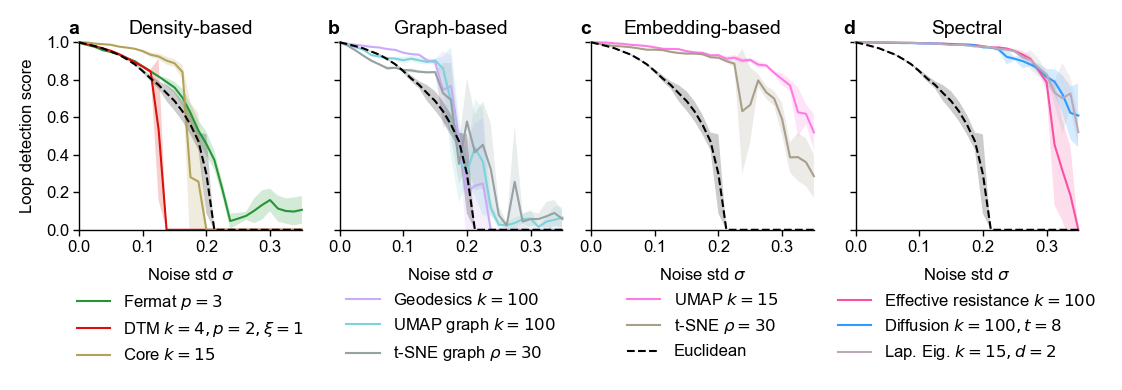

In [74]:
# plot figure
groups = [["fermat", "dtm", "core"], ["sknn_dist", "umap", "tsne"], ["umap_embd", "tsne_embd"], ["eff_res", "diffusion", "spectral"]]
panel_labels = ["Density-based", "Graph-based", "Embedding-based", "Spectral"]
letters = "abcd"

fig, ax = plt.subplots(ncols=len(groups),
                       figsize=(5.5, 5.5/3))


mean_eucl = outlier_scores["euclidean"]["euclidean"].mean(1)
std_eucl = outlier_scores["euclidean"]["euclidean"].std(1)


for i, group in enumerate(groups):
    for distance in group:
        for full_dist in outlier_scores[distance]:
            mean = outlier_scores[distance][full_dist].mean(1)
            std = outlier_scores[distance][full_dist].std(1)
            ax[i].plot(sigmas,
                       mean ,
                       label=full_dist_to_print[full_dist].replace("\n", " "),
                       c=dist_to_color[distance],
                       clip_on=False
            )
            ax[i].fill_between(sigmas,
                               mean+std,
                               mean-std,
                               alpha=0.2,
                               #color=full_dist_to_color[full_dist],
                               color=dist_to_color[distance],
                               edgecolor=None
                               )

    if i==2:
        ax[i].plot(sigmas, 
                   mean_eucl, 
                   c="k", 
                   linestyle="dashed", 
                   #label=full_dist_to_print["euclidean"], 
                   label=dist_to_print["euclidean"], 
                   clip_on=False)
    else:
                ax[i].plot(sigmas, mean_eucl, c="k", linestyle="dashed", clip_on=False)

    ax[i].fill_between(sigmas,
                       mean_eucl+std_eucl,
                       mean_eucl-std_eucl,
                       color="k",
                       alpha=0.2,
                       edgecolor=None)
    
    ax[i].legend(loc='upper center',
                 bbox_to_anchor=(0.5, -0.25),
                 frameon=False
          )

    
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0, 0.35)
    ax[i].set_xlabel("Noise std $\sigma$")
    if i==0:
        ax[i].set_ylabel("Loop detection score")
        
    if i > 0:
        ax[i].set_yticklabels([])
        
    ax[i].set_title(panel_labels[i])
    ax[i].set_title(
        letters[i],
        loc="left",
        ha="right",
        fontweight="bold",
)
    
fig.savefig(os.path.join(fig_path, "fig_toy_circle_dob.pdf"))

# Fig eff res on circle

In [75]:
distances = {
    "euclidean": [{}],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True},
        {"corrected": True, "weighted": True, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": True, "k": 100, "disconnect": True},
        {"corrected": False, "weighted": True, "k": 15, "disconnect": True},
        {"corrected": False, "weighted": True, "k": 100, "disconnect": True},

    ],

}

n = 1000
embd_dim = 50
sigmas = np.linspace(0.0, 0.35, 29)
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = [0, 1, 2]

In [76]:
all_res = load_multiple_res(datasets="toy_circle", distances=distances, root_path=root_path, n=n, embd_dims=embd_dim, sigmas=sigmas, seeds=seeds, n_threads=10)

Done with toy_circle 50 euclidean
Done with toy_circle 50 eff_res_corrected_True_weighted_False_k_15_disconnect_True
Done with toy_circle 50 eff_res_corrected_True_weighted_False_k_100_disconnect_True
Done with toy_circle 50 eff_res_corrected_True_weighted_True_k_15_disconnect_True
Done with toy_circle 50 eff_res_corrected_True_weighted_True_k_100_disconnect_True
Done with toy_circle 50 eff_res_corrected_False_weighted_True_k_15_disconnect_True
Done with toy_circle 50 eff_res_corrected_False_weighted_True_k_100_disconnect_True


In [77]:
# take square root of birth and death times to obtain the diagram corresponding to squared eff res
for dist in list(all_res["eff_res"])[:2]:
    all_res["eff_res"][dist+"_sqrt"] = transform_dgms(all_res["eff_res"][dist], transformation="sqrt")

In [78]:
# filtering
dob = 1.25
all_res = filter_dgms(all_res, dob=dob, dim=1, binary=True)

In [79]:
# compute detection scores
outlier_scores = compute_outlier_scores(dgms=all_res, n_features=1, dim=1)

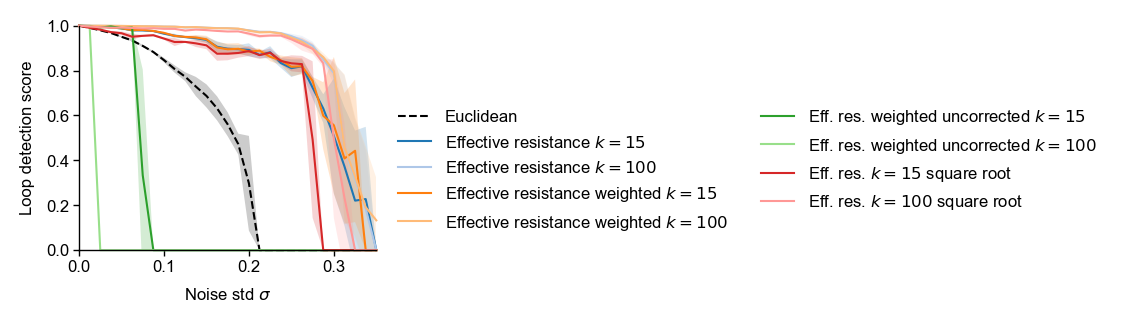

In [80]:
# plot figure
fig, ax = plt.subplots(figsize=(5.5, 1.5))

cmap = plt.get_cmap("tab20")

for i, distance in enumerate(outlier_scores):
    
    for j, dist_str in enumerate(outlier_scores[distance]):
        mean = outlier_scores[distance][dist_str].mean(1)
        std = outlier_scores[distance][dist_str].std(1)
        color = cmap(j) if distance != "euclidean" else "k"
        linestyle = "dashed" if distance == "euclidean" else "solid"
        ax.plot(sigmas,
                mean,
                c=color,
                clip_on=False,
                label=full_dist_to_print[dist_str].replace("\n", " "),
                linestyle=linestyle,
                
                )
        ax.fill_between(sigmas,
                        mean+std,
                        mean-std,
                        alpha=0.2,
                        color=color,
                        edgecolor=None)
        
ax.legend(frameon=False, loc = (1.05, 0.05), ncols=2)
        
ax.set_ylim(0, 1)
ax.set_xlim(0, 0.35)
ax.set_xlabel("Noise std $\sigma$")
ax.set_ylabel("Loop detection score")

fig.savefig(os.path.join(fig_path, "fig_toy_circle_eff_res.pdf"))